In [1]:
import torch
import numpy as np

import os
os.chdir('..')
from torch_geometric.loader import DataLoader
from gnn_library.util import train, save, load
from evaluate import evaluate_model, pp_output
import instance_generator as ig
import torch_converter as tc
import evaluate as ev
from util import Dataset

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("PyTorch has version {}".format(torch.__version__))
print('Using device:', device)

PyTorch has version 2.0.0+cu117
Using device: cuda:0


In [13]:
args = {
    'processor':         'GENConv',
    'head':              'regression',
    'num_layers':        2,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        32,
    'node_feature_dim':  4,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        64,
    'output_dim':        1,
    'dropout':           0.35,
    'epochs':            25,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device
}

train_num = 100; test_num = 30

er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 2,
    'weighted': True
}
geom_config = {
    'graph_type': 'GEOM',
    'threshold': 0.2,
    'scaling': 1 / np.sqrt(2)
}

rng = np.random.default_rng()


train_instances = [
        *ig.sample_instances(9, 7, train_num, rng, **er_config),
        *ig.sample_instances(9, 7, train_num, rng, **ba_config),
        *ig.sample_instances(9, 7, train_num, rng, **geom_config),
    ]

test_instances = [
        *ig.sample_instances(9, 7, test_num, rng, **er_config),
        *ig.sample_instances(9, 7, test_num, rng, **ba_config),
        *ig.sample_instances(9, 7, test_num, rng, **geom_config),
    ]


train_data = Dataset(tc._instances_to_train_samples(train_instances, args['head']))
test_data = Dataset(tc._instances_to_train_samples(test_instances, args['head']))

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

KeyboardInterrupt: 

In [7]:
_, _, GNN, _ = train(train_loader, test_loader, args)

Training:   0%|          | 0/25 [00:00<?, ?Epochs/s]

0.10291066506606346


Training:   4%|▍         | 1/25 [00:02<01:05,  2.75s/Epochs]

TEST LOSS: 0.06727086007595062


Training:   8%|▊         | 2/25 [00:04<00:53,  2.34s/Epochs]

0.0639278085572676
0.04505072483092988


Training:  12%|█▏        | 3/25 [00:07<00:56,  2.55s/Epochs]

TEST LOSS: 0.03116420842707157


Training:  16%|█▌        | 4/25 [00:09<00:48,  2.29s/Epochs]

0.03660079889135872
0.03242848244834279


Training:  20%|██        | 5/25 [00:11<00:47,  2.36s/Epochs]

TEST LOSS: 0.024624736979603767


Training:  24%|██▍       | 6/25 [00:13<00:41,  2.19s/Epochs]

0.029672764421951388
0.02628691123884558


Training:  28%|██▊       | 7/25 [00:16<00:41,  2.29s/Epochs]

TEST LOSS: 0.021705593913793564


Training:  32%|███▏      | 8/25 [00:18<00:36,  2.17s/Epochs]

0.025080816877101335
0.022262447272486652


Training:  36%|███▌      | 9/25 [00:20<00:36,  2.31s/Epochs]

TEST LOSS: 0.016465285792946815


Training:  40%|████      | 10/25 [00:22<00:32,  2.13s/Epochs]

0.02086506172309856
0.019566667544693665


Training:  44%|████▍     | 11/25 [00:25<00:32,  2.29s/Epochs]

TEST LOSS: 0.015860730782151222


Training:  48%|████▊     | 12/25 [00:27<00:29,  2.25s/Epochs]

0.01898238259678627
0.017794555082345592


Training:  52%|█████▏    | 13/25 [00:30<00:28,  2.38s/Epochs]

TEST LOSS: 0.013727412559092045


Training:  56%|█████▌    | 14/25 [00:31<00:24,  2.19s/Epochs]

0.016856952022303157
0.016472969990168434


Training:  60%|██████    | 15/25 [00:34<00:23,  2.36s/Epochs]

TEST LOSS: 0.013300866819918156


Training:  64%|██████▍   | 16/25 [00:36<00:20,  2.30s/Epochs]

0.015285684607773629
0.015309341834840196


Training:  68%|██████▊   | 17/25 [00:39<00:19,  2.44s/Epochs]

TEST LOSS: 0.011798766441643238


Training:  72%|███████▏  | 18/25 [00:41<00:15,  2.26s/Epochs]

0.014936636793959006
0.014485554334422559


Training:  76%|███████▌  | 19/25 [00:43<00:14,  2.36s/Epochs]

TEST LOSS: 0.011897599324584007


Training:  80%|████████  | 20/25 [00:45<00:11,  2.22s/Epochs]

0.013873385055170905
0.014044516210776365


Training:  84%|████████▍ | 21/25 [00:48<00:09,  2.32s/Epochs]

TEST LOSS: 0.010904124937951565


Training:  88%|████████▊ | 22/25 [00:50<00:06,  2.21s/Epochs]

0.013700027833997215
0.01332170740029764


Training:  92%|█████████▏| 23/25 [00:52<00:04,  2.31s/Epochs]

TEST LOSS: 0.01019977405667305


Training:  96%|█████████▌| 24/25 [00:54<00:02,  2.16s/Epochs]

0.012718850244957152
0.012588007239188022


Training: 100%|██████████| 25/25 [00:57<00:00,  2.30s/Epochs]

TEST LOSS: 0.00998975895345211


In [12]:
save(GNN, args, 'GNN3')

In [ ]:
GNN, args = load('test_GNN', device)

In [11]:
seed = np.random.randint(0, 500000)
(m, n) = (8, 16)
config = er_config

rng = np.random.default_rng(seed)
eval_instances = ig.sample_instances(m, n, 10, rng, **config)

ratios2 = evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

pp_output(ratios2, _, show_log=False)

(array([0]), array([50]))
-- Competitive ratios --
GNN: 0.944
Greedy: 0.9943


# Pivot to feature-generated graphs

In [36]:
args = {
    'processor':         'GENConv',
    'head':              'regression',
    'num_layers':        2,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        32,
    'node_feature_dim':  4,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        64,
    'output_dim':        1,
    'dropout':           0.35,
    'epochs':            25,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device
}

train_num = 100; test_num = 30

er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': False
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 2,
    'weighted': False
}
feat_config = {
    'graph_type': 'FEAT',
    'q': 0.2
}

rng = np.random.default_rng()


train_instances = [
        *ig.sample_instances(8, 8, train_num, rng, **er_config),
        *ig.sample_instances(8, 8, train_num, rng, **ba_config),
        *ig.sample_instances(8, 8, train_num, rng, **feat_config),
    ]

test_instances = [
        *ig.sample_instances(8, 8, test_num, rng, **er_config),
        *ig.sample_instances(8, 8, test_num, rng, **ba_config),
        *ig.sample_instances(8, 8, test_num, rng, **feat_config),
    ]


train_data = Dataset(tc._instances_to_train_samples(train_instances, args['head']))
test_data = Dataset(tc._instances_to_train_samples(test_instances, args['head']))

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [37]:
_, _, GNN, _ = train(train_loader, test_loader, args)

Training:   0%|          | 0/25 [00:00<?, ?Epochs/s]

0.17175870046178887


Training:   4%|▍         | 1/25 [00:02<01:11,  2.99s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.11428944766521454


Training:   8%|▊         | 2/25 [00:05<00:59,  2.58s/Epochs]

0.09360097265559426
0.07740642366258003


Training:  12%|█▏        | 3/25 [00:07<00:58,  2.64s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.052912287414073944


Training:  16%|█▌        | 4/25 [00:09<00:49,  2.37s/Epochs]

0.06968462177275614
0.06379828871210914


Training:  20%|██        | 5/25 [00:12<00:51,  2.56s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.04365994781255722


Training:  24%|██▍       | 6/25 [00:15<00:46,  2.44s/Epochs]

0.059852354034525136
0.05507338277715021


Training:  28%|██▊       | 7/25 [00:17<00:46,  2.60s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.044129643589258194


Training:  32%|███▏      | 8/25 [00:20<00:41,  2.44s/Epochs]

0.05085472112780447
0.048089986709468256


Training:  36%|███▌      | 9/25 [00:22<00:41,  2.57s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.04804784804582596


Training:  40%|████      | 10/25 [00:24<00:35,  2.37s/Epochs]

0.04559403195066238
0.04320193055942689


Training:  44%|████▍     | 11/25 [00:27<00:35,  2.55s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.040975864976644516


Training:  48%|████▊     | 12/25 [00:29<00:30,  2.38s/Epochs]

0.040197930719161355
0.037645031443893605


Training:  52%|█████▏    | 13/25 [00:32<00:30,  2.50s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.038384873420000076


Training:  56%|█████▌    | 14/25 [00:34<00:25,  2.35s/Epochs]

0.03616045028324573
0.03350288820721864


Training:  60%|██████    | 15/25 [00:37<00:25,  2.52s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.03599034249782562


Training:  64%|██████▍   | 16/25 [00:39<00:21,  2.36s/Epochs]

0.03163399933376239
0.02935673163788976


Training:  68%|██████▊   | 17/25 [00:42<00:19,  2.45s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.0372585766017437


Training:  72%|███████▏  | 18/25 [00:44<00:16,  2.34s/Epochs]

0.028432987947302715
0.026963800668581343


Training:  76%|███████▌  | 19/25 [00:47<00:14,  2.49s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.028823303058743477


Training:  80%|████████  | 20/25 [00:49<00:12,  2.42s/Epochs]

0.026067933652191483
0.025025737577956647


Training:  84%|████████▍ | 21/25 [00:52<00:10,  2.54s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.026728786528110504


Training:  88%|████████▊ | 22/25 [00:54<00:07,  2.42s/Epochs]

0.024283085591651186
0.022332200693050575


Training:  92%|█████████▏| 23/25 [00:57<00:05,  2.57s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.023690104484558105


Training:  96%|█████████▌| 24/25 [00:59<00:02,  2.44s/Epochs]

0.022134539679035732
0.021566722459782837


Training: 100%|██████████| 25/25 [01:02<00:00,  2.50s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 0.023204753175377846


In [38]:
seed = np.random.randint(0, 500000)
(m, n) = (32, 16)
config = {
    'graph_type': 'FEAT',
    'q': 0.75
}

rng = np.random.default_rng(seed)
eval_instances = ig.sample_instances(m, n, 100, rng, **config)

ratios2 = ev.evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

pp_output(ratios2, _, show_log=False)

-- Competitive ratios --
GNN: 0.9769
Greedy: 0.8998


In [39]:
num_trials = 50
node_configs = [(x, 16) for x in np.arange(4, 64, 4)]
# of nodes [20 -> 80]
# of nodes in batch [10,000 -> 40,000]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]
graph_configs = [
    # {
    #     'graph_type': 'GM'
    # },
    {
        'graph_type': 'ER',
        'p': 0.75,
        'weighted': False
    },
    {
        'graph_type': 'BA',
        'ba_param': 4,
        'weighted': False
    },
    {
    'graph_type': 'FEAT',
    'q': 0.75
    }
]

ratios = [x/y for (x,y) in node_configs]
print(ratios)
data = {config['graph_type']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(graph_config, node_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, **graph_config)


        rng = np.random.default_rng(seed)
        gnn_learned_ratios, greedy_ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )


        data[graph_config['graph_type']].append(np.array(
            [
                gnn_learned_ratios,
                greedy_ratios
            ]
        ))

[0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75]
{'graph_type': 'ER', 'p': 0.75, 'weighted': False} (4, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': False} (8, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': False} (12, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': False} (16, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': False} (20, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': False} (24, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': False} (28, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': False} (32, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': False} (36, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': False} (40, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': False} (44, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': False} (48, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': False} (52, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': False} (56, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': False} (60, 16)
{'graph_type': 'BA

/home/wikum/GNN-OBM/evaluate.py:324: RuntimeWarning: Mean of empty slice
  np.nanmean(learned_ratios, axis=1),
/home/wikum/GNN-OBM/evaluate.py:325: RuntimeWarning: Mean of empty slice
  np.nanmean(greedy_ratios, axis=1),


{'graph_type': 'FEAT', 'q': 0.75} (8, 16)
{'graph_type': 'FEAT', 'q': 0.75} (12, 16)
{'graph_type': 'FEAT', 'q': 0.75} (16, 16)
{'graph_type': 'FEAT', 'q': 0.75} (20, 16)
{'graph_type': 'FEAT', 'q': 0.75} (24, 16)
{'graph_type': 'FEAT', 'q': 0.75} (28, 16)
{'graph_type': 'FEAT', 'q': 0.75} (32, 16)
{'graph_type': 'FEAT', 'q': 0.75} (36, 16)
{'graph_type': 'FEAT', 'q': 0.75} (40, 16)
{'graph_type': 'FEAT', 'q': 0.75} (44, 16)
{'graph_type': 'FEAT', 'q': 0.75} (48, 16)
{'graph_type': 'FEAT', 'q': 0.75} (52, 16)
{'graph_type': 'FEAT', 'q': 0.75} (56, 16)
{'graph_type': 'FEAT', 'q': 0.75} (60, 16)


ER


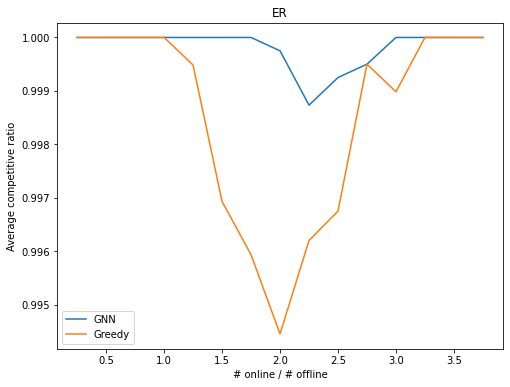

BA


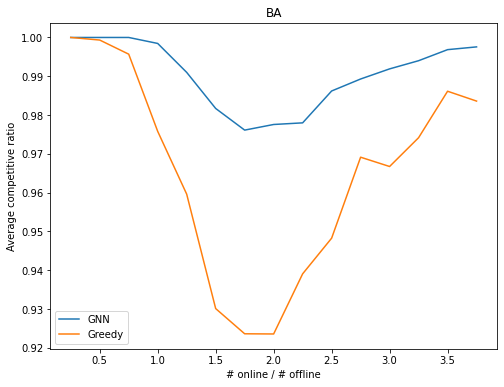

FEAT


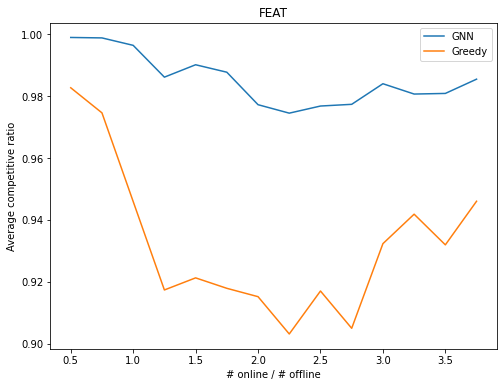

In [40]:
import matplotlib.pyplot as plt
ratios = [x/y for (x,y) in node_configs]
for graph_type, comp_ratios in data.items():
    greedy_avg_ratios = []
    gnn_avg_ratios = []


    for trial_ratios in comp_ratios:
        gnn_avg_ratios.append(np.array(trial_ratios[0]).mean())
        greedy_avg_ratios.append(np.array(trial_ratios[1]).mean())

    print(graph_type)
    fig = plt.figure(figsize=(8,6))
    plt.title(graph_type)
    plt.plot(ratios, gnn_avg_ratios, label='GNN')
    plt.plot(ratios, greedy_avg_ratios, label='Greedy')
    plt.xlabel('# online / # offline')
    plt.ylabel('Average competitive ratio')
    plt.legend()
    plt.show()
